In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

**Описание задачи:**

Сайт запустил A\B-тест с целью увеличения дохода. Данные о результате эксперимента содержат информацию о пользователе (user_id), типе группы (variant_name) и доходе, принесенном пользователем (revenue).

Задача — проанализировать результаты A\B-теста и дать рекомендации.

**План работы:**
1. Разведочный анализ и предобработка данных.


2. Статистический анализ результатов A\B- теста.

   2.1 Тест Шапиро-Уилка для проверки нормальности распределения revenue в группах.
   
   2.2 Тест Манна-Уитни для проверки различия групп variant и control по уровню revenue.


3. Вывод и рекомендации.

## 1. Разведочный анализ и предобработка данных.

In [2]:
df = pd.read_csv('AB_Test_data.csv')

In [3]:
# посмотрим на набор данных
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [4]:
# для удобства изменим регистр имен столбцов на нижний
df.columns = df.columns.str.lower()
df.head(3)

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10000 non-null  int64  
 1   variant_name  10000 non-null  object 
 2   revenue       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Всего имеется 10 000 наблюдений, при этом пропусков в данных нет. Посмотрим, есть ли пользователи, которые попали в как в контрольную группу, так и в тестовую.

In [6]:
df.groupby('user_id')['variant_name'].nunique().value_counts()

1    4783
2    1541
Name: variant_name, dtype: int64

Видно, что есть пользователи, которые попали в обе группы. Анализ результатов аб-теста будет искажен, если не убрать из рассмотрения такие наблюдения.

In [7]:
duplicates = df.groupby('user_id')['variant_name'].nunique() > 1
duplicates = duplicates[duplicates].index
df = df[~df['user_id'].isin(duplicates)]
df.shape[0]

6070

После того, как мы убрали пользователей, которые были в обеих группах, осталось 6070 наблюдений. Посмотрим как среди них соотносятся наблюдения с нулевым и положительным revenue.

In [8]:
df1 = pd.DataFrame(data = {'total': df.groupby('variant_name')['revenue'].count(), 
                     'positive_revenue': df[df.revenue > 0].groupby('variant_name')['revenue'].count()}, 
            index = ['variant', 'control'])

df1['percent_of_positive_revenue'] = round(100 * df1['positive_revenue'] / df1['total'], 2)
df1.T

,variant,control
total,3044.00,3026.00
positive_revenue,43.00,54.00
percent_of_positive_revenue,1.41,1.78


Видно, что доля пользователей с ненулевым revenue очень мала.

С помощью ящика с усами посмотрим, как распределен revenue в контрольной и тестовой группе.

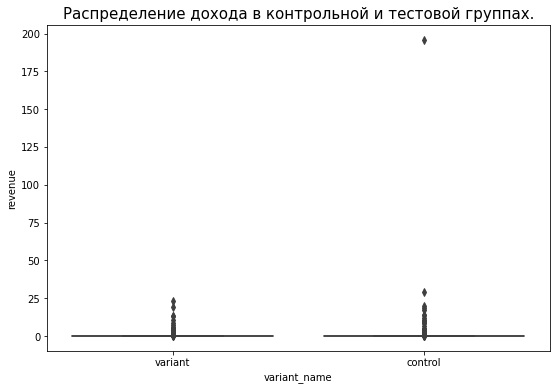

In [9]:
plt.figure(figsize = (9, 6))
plt.title('Распределение дохода в контрольной и тестовой группах.', fontsize = 15)
sns.boxplot(data=df, x='variant_name', y='revenue');

Неольшое число наблюдений с ненулевым revenue видны на графике как выбросы. Однако даже среди них есть один явный выделяющийся выброс. Уберем наблюдение с этим сильным выбросом из рассмотрения.

In [10]:
# наблюдение с выбросом
df[df.revenue == df.revenue.max()]

,user_id,variant_name,revenue
1437,3342,control,196.01


In [11]:
# удаление выброса
df = df[df.revenue != df.revenue.max()]

Посмотрим, как распределен доход в контрольной и тестовой группе теперь.

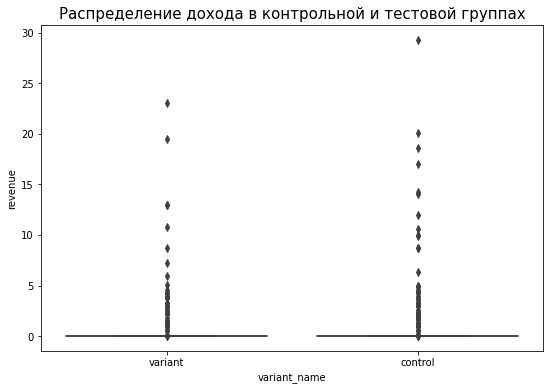

In [12]:
plt.figure(figsize = (9, 6))
plt.title('Распределение дохода в контрольной и тестовой группах', fontsize = 15)
sns.boxplot(data=df, x='variant_name', y='revenue');

In [13]:
# для анализа результатов A\B-теста разделим данные по признаку variant_name
v = df[df['variant_name'] == 'variant']
c = df[df['variant_name'] == 'control']
v.shape[0], c.shape[0]

(3044, 3025)

## 2. Статистический анализ результатов A\B- теста.

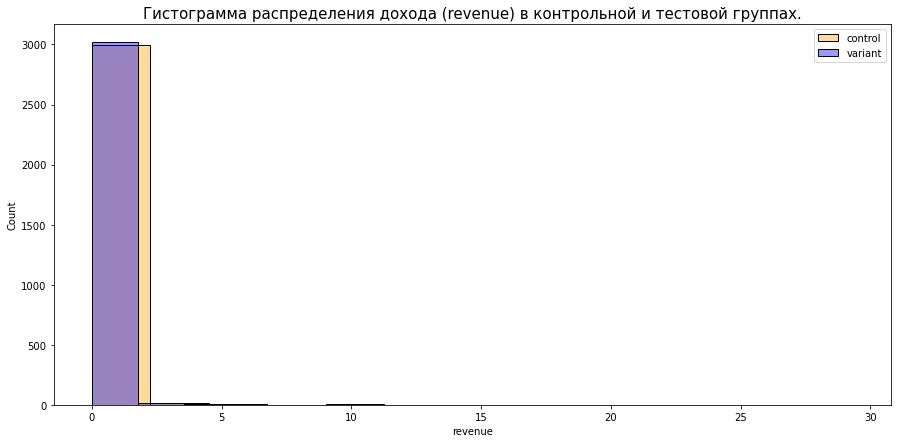

In [14]:
plt.figure( figsize = (15, 7))
plt.title('Гистограмма распределения дохода (revenue) в контрольной и тестовой группах.', fontsize = 15)
sns.histplot(c.revenue, alpha = 0.4, color = 'orange', label = 'control')
sns.histplot(v.revenue, alpha = 0.4, color = 'blue', label = 'variant')
plt.legend();

По графику видно, что в обеих группах распределение существенно отлично от нормального. С помощью теста Шапиро-Уилка проверим более формально, соответствуют ли данные в группах нормальному распределениию.

### 2.1. Тест Шапиро-Уилка для проверки нормальности распределения revenue в группах.

**alpha = 0.05**

**H0:** данные в группе распределены по нормальному закону.

**H1:** данные в группе не распределены по нормальному закону.

In [15]:
stats.shapiro(v.revenue)

ShapiroResult(statistic=0.051010727882385254, pvalue=0.0)

In [16]:
stats.shapiro(c.revenue)

ShapiroResult(statistic=0.062157392501831055, pvalue=0.0)

Для обеих групп **pvalue < alpha**, поэтому на уровне значимости alpha = 0.05 **отвергаем H0**.

Так как данные в группах variant и control не распределены по нормальному закону, **проверять предпосылку о равенстве дисперсий в группах нет смысла.** Поэтому для проверки гипотезы о наличии/отсутствии влияния изменений аб-теста
на revenue будем использовать непараметрический тест Манна-Уитни.

### 2.2. Тест Манна-Уитни для проверки различия групп variant и control по уровню revenue.

**alpha = 0.05**

**H0:** статистически значимых различий между группами нет.

**H1:** статистически значимые различия между группами есть.

In [17]:
stats.mannwhitneyu(v.revenue, c.revenue)

MannwhitneyuResult(statistic=4588312.0, pvalue=0.14299211543097756)

## 3. Вывод и рекомендации.

Так как p-value > alpha, H0 на уровне значимости alpha = 0.05 **не отвергаем**, то есть между группами *variant* и *control* нет статистически значимых различий по признаку *revenue*.

По результатам анализа аб-теста мы выяснили, что тестируемые изменения не привели к статистически значимым различиям по признаку *revenue* между группами *variant* и *control*. Поэтому **внедрять изменения, которые были протестированы с помощью этого аб-теста, не имеет смысла**.